# Introduction
This jupyter notebook is accompanied with [MBTI Twitter personality classsification](https://www.github.com/sahilsehwag/twitter-mbti-personality-classifier) project. This notebook is created to easily explore our dataset, perform analysis and perform modelling. To use the final classifier refer to [README.md](https://www.github.com/sahilsehwag/twitter-mbti-personality-classifier) file of this project. Use [main.py](https://github.com/sahilsehwag/twitter-mbti-personality-classifier/blob/master/main.py) to perform personality classification on any twitter user.
<br>
### Dataset
The [dataset](https://github.com/sahilsehwag/twitter-mbti-personality-classifier/blob/master/personality-test.csv) on which this classifier is trained, contains around 50 posts per user about 8000 users with their *MBTI*
personality type known. Dataset is provided in the repo itself [personality-test.csv](https://github.com/sahilsehwag/twitter-mbti-personality-classifier/blob/master/personality-test.csv).
<br>
Few features of dataset are:
* Posts of more than 8000 users.
* Last 50 posts per user, each entry is separated by '|||'.

### Challenges
The main challenge with this particular dataset is the imbalance in dataset. The dataset is hugely imbalanced. I have tackled this problem by training a model for each characteristic pair. There is imbalance in different characteristic pair like IE pair. Different solutions to this problem are stated in below sections.

# Setup

## Helper Methods

In [1]:
#printing on single line
def printl(msg):
    sys.stdout.write("\r" + str(msg))
    sys.stdout.flush()


#pickler
def save(filepath, obj):
    with open(filepath, 'wb') as file:
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)


#unpickler
def load(filepath):
    return pickle.load(filepath)

## Imports

In [2]:
import sys
import re
import string
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals import joblib

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

import tweepy

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Loading Dataset
I will add one column for each MBTI characteristic pair, since we will be training independent classifier model 
for each pair independently. The reason for this is because of imbalance present in our dataset. For example posts of 
introverts are very large as compared to extroverts. To understand and visualize this go to [**EDA**](#EDA-(Exploratory-Data-Analysis&#41;) section.

In [3]:
%%time
df = pd.read_csv('personality-test.csv')
df['ie'] = df.type
df['ns'] = df.type
df['ft'] = df.type
df['pj'] = df.type

for i, t in enumerate(df.type):
    if 'I' in t:
        df.ie[i] = 'I'
    elif 'E' in t:
        df.ie[i] = 'E'
        
    if 'N' in t:
        df.ns[i] = 'N'
    elif 'S' in t:
        df.ns[i] = 'S'
        
    if 'F' in t:
        df.ft[i] = 'F'
    elif 'T' in t:
        df.ft[i] = 'T'
        
    if 'P' in t:
        df.pj[i] = 'P'
    elif 'J' in t:
        df.pj[i] = 'J'


posts = df.posts.values
yIE = df.ie.values
yNS = df.ns.values
yFT = df.ft.values
yPJ = df.pj.values
y = df.type

CPU times: user 3.16 s, sys: 92.2 ms, total: 3.26 s
Wall time: 3.27 s


## Preprocessing
NOTE: this phase might take some time to execute due to computationaly expensive operations

In [4]:
#regular expressions for tokenization
regexes = [
    #urls
    #r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    
    #html
    #r'<[^>]+>',
    
    #punctuation
    r'(?:(\w+)\'s)',
    
    r'(?:\s(\w+)\.+\s)',
    r'(?:\s(\w+),+\s)',
    r'(?:\s(\w+)\?+\s)',
    r'(?:\s(\w+)!+\s)',
    
    r'(?:\'+(\w+)\'+)',
    r'(?:"+(\w+)"+)',
    r'(?:\[+(\w+)\]+)',
    r'(?:{+(\w+)}+)',
    r'(?:\(+(\w+))',
    r'(?:(\w+)\)+)',

    #words containing numbers & special characters & punctuation
    r'(?:(?:(?:[a-zA-Z])*(?:[0-9!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~])+(?:[a-zA-Z])*)+)',
    
    #pure words
    r'([a-zA-Z]+)',
    
    #numbers
    #r'(?:(?:\d+,?)+(?:\.?\d+)?)',

    #emoticons
    #r"""(?:[:=;][oO\-]?[D\)\]\(\]/\\OpP])""",

    #other words
    #r'(?:[\w_]+)',

    #anything else
    #r'(?:\S)'
]

#compiling regular expression
regex = re.compile(r'(?:'+'|'.join(regexes)+')', re.VERBOSE | re.IGNORECASE)


def preprocess(documents):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    #fetching list of stopwords
    punctuation = list(string.punctuation)
    swords = stopwords.words('english') + ['amp'] + ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',  'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',  'jan', 'feb', 'mar', 'apr', 'may', 'jun' 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'tommorow', 'today', 'yesterday'] + ['mr', 'mrs']


    processed_documents = []
    for i,document in enumerate(documents):
        printl('{0}/{1}'.format(i+1, len(documents)))
        
        #tokenization
        tokens = regex.findall(document)

        #skipping useless tokens
        t_regex = re.compile(r"[^a-zA-Z]")
        document = []
        
        for token in tokens:
            token = np.array(token)
            token = np.unique(token[token != ''])
            
            if len(token) > 0:
                token = token[0].lower()
            else:
                continue
                
            if re.search(t_regex, token) == None and token not in swords:
                token = lemmatizer.lemmatize(token)
                document.append(token)
                
        document = ' '.join(document)

        #skipping
        if len(document) > 0:
            processed_documents.append(document)

    print()
    return np.array(processed_documents)

In [5]:
%%time
# posts = preprocess(posts)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


# Processing

I am only using document matrix, using TF-IDF weighing scheme will actually result in model's performance degradation. I think the reason is because our document are relatively small in nature due to small size nature of tweets.

In [6]:
%%time
# creating document frequency matrix
cv = CountVectorizer().fit(posts)
X = cv.transform(posts)

CPU times: user 14.4 s, sys: 104 ms, total: 14.5 s
Wall time: 14.6 s


### Splitting Dataset

In [7]:
# splitting dataset into training and testing dataset
xIETrain, xIETest, yIETrain, yIETest = train_test_split(X, yIE)
xNSTrain, xNSTest, yNSTrain, yNSTest = train_test_split(X, yNS)
xFTTrain, xFTTest, yFTTrain, yFTTest = train_test_split(X, yFT)
xPJTrain, xPJTest, yPJTrain, yPJTest = train_test_split(X, yPJ)
xTrain, xTest, yTrain, yTest = train_test_split(X, y)

# EDA (Exploratory Data Analysis)

As we can see that our dataset has disproportionate data. Due to this **heavy unbalance** in our dataset we will
be training our classifiers independently for each characteristic pair. This unbalance makes it very difficult 
to work with different algorithms, specially probability based models. To look at this, refer to cells below in this section. For analysing the effect of this balance in machine learning algorithms using conventional approaches look at [result analysis section](#Analysing-our-Models-Results).

This problem is called **Imbalanced Classification Problem**. Generally there are two approaches to tackle this kind of problem:
* **Sampling**<br>
    There are different sampling techniques to tackle this problem, we will be discussing few of them.
    * *Random Sampling*
    * *SMOTE*
    * *Modified SMOTE*
* **Ensemble Methods**

I will be using type of *random sampling* technique called **undersampling**, In this approach we will randomly remove our sample instances from majority class until the size of majority class instances are equal to minority class instances.

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


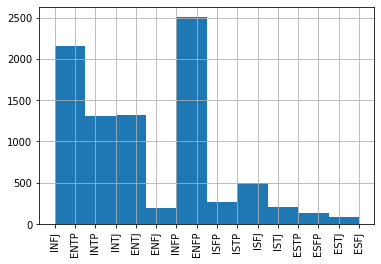

In [8]:
print(df.type.value_counts())
df.type.hist(xrot=90)
plt.show()

In cell below we can see that there is great **unbalance** in **Introvert/Extrovert** and **Intuition/Sensing** pairs. Whereas **Feeling/Thinking** and **Perception/Judgment** pairs are quite *balanced*. Although I have created trained models for each pair. Only last 2 pairs are somewhat reliable in predicting MBTI type. So it is
not advised to depend on first 2 pairs i.e. **IE** and **NS** pairs. For analysis of results of various trained models is present below in [result analysis section](#Analysing-our-Models-Results)

I    6676
E    1999
Name: ie, dtype: int64

N    7478
S    1197
Name: ns, dtype: int64

F    4694
T    3981
Name: ft, dtype: int64

P    5241
J    3434
Name: pj, dtype: int64



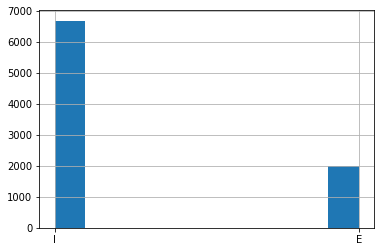

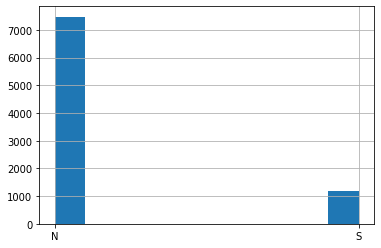

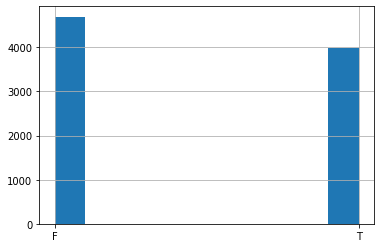

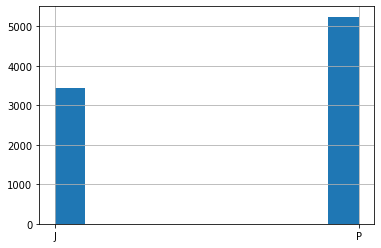

In [9]:
print(df.ie.value_counts(), end='\n\n')
print(df.ns.value_counts(), end='\n\n')
print(df.ft.value_counts(), end='\n\n')
print(df.pj.value_counts(), end='\n\n')

df.ie.hist(); plt.show()
df.ns.hist(); plt.show()
df.ft.hist(); plt.show()
df.pj.hist(); plt.show()

# Modelling

### Training our Models

In [10]:
%%time
%time model = MultinomialNB().fit(xTrain, yTrain)
%time ieModel = MultinomialNB().fit(xIETrain, yIETrain)
%time nsModel = MultinomialNB().fit(xNSTrain, yNSTrain)
%time ftModel = MultinomialNB().fit(xFTTrain, yFTTrain)
%time pjModel = MultinomialNB().fit(xPJTrain, yPJTrain)

CPU times: user 186 ms, sys: 27 ms, total: 212 ms
Wall time: 214 ms
CPU times: user 55.4 ms, sys: 1.02 ms, total: 56.4 ms
Wall time: 55.8 ms
CPU times: user 60 ms, sys: 995 µs, total: 61 ms
Wall time: 60.4 ms
CPU times: user 58.5 ms, sys: 21 µs, total: 58.5 ms
Wall time: 58.1 ms
CPU times: user 64.7 ms, sys: 0 ns, total: 64.7 ms
Wall time: 64 ms
CPU times: user 430 ms, sys: 29.1 ms, total: 459 ms
Wall time: 457 ms


### Testing our Models

As we can see our models performed relatively well despite the weaknesses present in our dataset. Although this accuracy is **superficial** in the cases of first 2 models i.e. **IE** and **NS**. The reason being that these are heavily biased towards a single characteristic value. This will be evident in [result analysis section](#Analysing-our-Models-Results) below.
Our accuracy is just high because our most of data is belonging to one instance. Introvert for example in IE model.

In [11]:
print(model.score(xTest, yTest))
print(ieModel.score(xIETest, yIETest))
print(nsModel.score(xNSTest, yNSTest))
print(ftModel.score(xFTTest, yFTTest))
print(pjModel.score(xPJTest, yPJTest))

0.3397879207007838
0.7754725680036884
0.8450899031811895
0.8054402950668511
0.7081604426002767


Instead of accuracy, which is a bad metric for imbalance dataset, we will be using **recall** and **f1 score**, to measure our model performance.

In [12]:
#minority classes
print('MINORITY CLASSES:')
print(recall_score(yIETest, ieModel.predict(xIETest), pos_label='E'))
print(recall_score(yNSTest, nsModel.predict(xNSTest), pos_label='S'))
print(recall_score(yFTTest, ftModel.predict(xFTTest), pos_label='T'))
print(recall_score(yPJTest, pjModel.predict(xPJTest), pos_label='J'), end='\n\n')

#majority classes
print('MAJORITY CLASSES:')
print(recall_score(yIETest, ieModel.predict(xIETest), pos_label='I'))
print(recall_score(yNSTest, nsModel.predict(xNSTest), pos_label='N'))
print(recall_score(yFTTest, ftModel.predict(xFTTest), pos_label='F'))
print(recall_score(yPJTest, pjModel.predict(xPJTest), pos_label='P'))

MINORITY CLASSES:
0.1483739837398374
0.0851063829787234
0.7321428571428571
0.4287369640787949

MAJORITY CLASSES:
0.9594514013118665
0.958664546899841
0.8690783807062877
0.892802450229709


In [13]:
#minority classes
print('MINORITY CLASSES:')
print(f1_score(yIETest, ieModel.predict(xIETest), pos_label='E'))
print(f1_score(yNSTest, nsModel.predict(xNSTest), pos_label='S'))
print(f1_score(yFTTest, ftModel.predict(xFTTest), pos_label='T'))
print(f1_score(yPJTest, pjModel.predict(xPJTest), pos_label='J'), end='\n\n')

#majority classes
print('MAJORITY CLASSES:')
print(f1_score(yIETest, ieModel.predict(xIETest), pos_label='I'))
print(f1_score(yNSTest, nsModel.predict(xNSTest), pos_label='N'))
print(f1_score(yFTTest, ftModel.predict(xFTTest), pos_label='F'))
print(f1_score(yPJTest, pjModel.predict(xPJTest), pos_label='P'))

MINORITY CLASSES:
0.2306477093206951
0.125
0.7776606954689147
0.538965768390386

MAJORITY CLASSES:
0.8685560053981106
0.9150227617602428
0.8270491803278689
0.7865092748735245


For better analysis or testing of our model, we will be using classification report to see **recall** which is measure of how much right predictions we make per characteristic. *Accuracy* is bad *classification metric* in our case due to **imbalanced classification problem**. Recall will give us better insight.

In [14]:
print(classification_report(yTest, model.predict(xTest)), end='\n\n')

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        49
        ENFP       0.67      0.01      0.02       189
        ENTJ       0.00      0.00      0.00        66
        ENTP       0.40      0.01      0.02       158
        ESFJ       0.00      0.00      0.00        14
        ESFP       0.00      0.00      0.00         6
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        21
        INFJ       0.40      0.45      0.42       385
        INFP       0.29      0.89      0.43       441
        INTJ       0.58      0.12      0.20       277
        INTP       0.45      0.41      0.43       333
        ISFJ       0.00      0.00      0.00        34
        ISFP       0.00      0.00      0.00        57
        ISTJ       0.00      0.00      0.00        47
        ISTP       0.00      0.00      0.00        84

    accuracy                           0.34      2169
   macro avg       0.17   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As it can be seen for first 2 pairs ie **IE** and **NS** the *recall* score is very low for minority classes. In first pair the recall score for "extroverts" is **0.13** which is amazingly bad.

In [15]:
print(classification_report(yIETest, ieModel.predict(xIETest)), end='\n\n')
print(classification_report(yNSTest, nsModel.predict(xNSTest)), end='\n\n')
print(classification_report(yFTTest, ftModel.predict(xFTTest)), end='\n\n')
print(classification_report(yPJTest, pjModel.predict(xPJTest)), end='\n\n')

              precision    recall  f1-score   support

           E       0.52      0.15      0.23       492
           I       0.79      0.96      0.87      1677

    accuracy                           0.78      2169
   macro avg       0.66      0.55      0.55      2169
weighted avg       0.73      0.78      0.72      2169


              precision    recall  f1-score   support

           N       0.88      0.96      0.92      1887
           S       0.24      0.09      0.12       282

    accuracy                           0.85      2169
   macro avg       0.56      0.52      0.52      2169
weighted avg       0.79      0.85      0.81      2169


              precision    recall  f1-score   support

           F       0.79      0.87      0.83      1161
           T       0.83      0.73      0.78      1008

    accuracy                           0.81      2169
   macro avg       0.81      0.80      0.80      2169
weighted avg       0.81      0.81      0.80      2169


              pr

### Cross Validation

To get actual performance of our models, I am using **KFold cross validation** with *k=10* to get actual performance. These values will be **pickled** along with models, so that these can be used in scripts to allow users to see
performance and reliability of each model corresponding to their characteristic pair.

In [16]:
scores = []

scores.append(cross_val_score(estimator=model, cv=10, X=X, y=y, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=10, X=X, y=LabelEncoder().fit_transform(yIE), scoring='recall'))
scores.append(cross_val_score(estimator=nsModel, cv=10, X=X, y=LabelEncoder().fit_transform(yNS), scoring='recall'))
scores.append(cross_val_score(estimator=ftModel, cv=10, X=X, y=LabelEncoder().fit_transform(yFT), scoring='recall'))
scores.append(cross_val_score(estimator=pjModel, cv=10, X=X, y=LabelEncoder().fit_transform(yPJ), scoring='recall'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.3770589829859837
0.011558744094853775

0.9526658826275485
0.010258951729609831

0.11861344537815126
0.024635189484677134

0.7420271784990113
0.016357892693655052

0.8572784442021083
0.010208014593669084



### Analysing our Models Results

In case of this model where we are predicting MBTI type using all characteristics together. It can be seen heavy bias in results of trained model.

INFP    441
INFJ    385
INTP    333
INTJ    277
ENFP    189
ENTP    158
ISTP     84
ENTJ     66
ISFP     57
ENFJ     49
ISTJ     47
ISFJ     34
ESTP     21
ESFJ     14
ESTJ      8
ESFP      6
Name: type, dtype: int64

INFP    1375
INFJ     427
INTP     298
INTJ      59
ENTP       5
ENFP       3
ISFP       2
dtype: int64


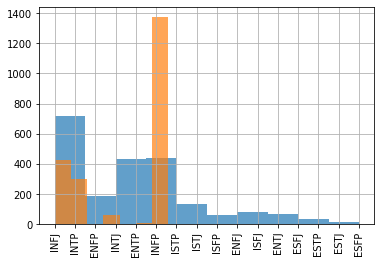

In [17]:
print(pd.Series(yTest).value_counts(), end='\n\n')
print(pd.Series(model.predict(xTest)).value_counts())

pd.Series(yTest).hist(xrot=90, alpha=0.7)
pd.Series(model.predict(xTest)).hist(xrot=90, alpha=0.7)
plt.show()

In next 2 models ie **IE** and **NS** models we can see that class distribution is heavily biased, this accounts for high accuracy in our results for these specific models.

I    1677
E     492
dtype: int64

I    2028
E     141
dtype: int64

              precision    recall  f1-score   support

           E       0.52      0.15      0.23       492
           I       0.79      0.96      0.87      1677

    accuracy                           0.78      2169
   macro avg       0.66      0.55      0.55      2169
weighted avg       0.73      0.78      0.72      2169



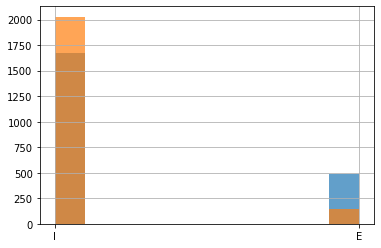

In [18]:
print(pd.Series(yIETest).value_counts(), end='\n\n')
print(pd.Series(ieModel.predict(xIETest)).value_counts(), end='\n\n')
print(classification_report(y_pred=ieModel.predict(xIETest), y_true=yIETest))

pd.Series(yIETest).hist(alpha=0.7)
pd.Series(ieModel.predict(xIETest)).hist(alpha=0.7)
plt.show()

N    1887
S     282
dtype: int64

N    2067
S     102
dtype: int64


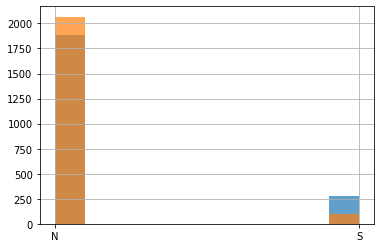

In [19]:
print(pd.Series(yNSTest).value_counts(), end='\n\n')
print(pd.Series(nsModel.predict(xNSTest)).value_counts())

pd.Series(yNSTest).hist(alpha=0.7)
pd.Series(nsModel.predict(xNSTest)).hist(alpha=0.7)
plt.show()

F    1161
T    1008
dtype: int64

F    1279
T     890
dtype: int64


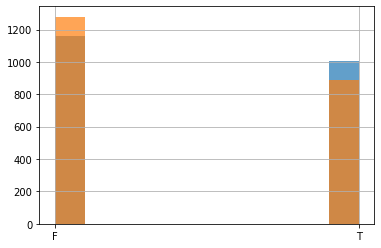

In [20]:
print(pd.Series(yFTTest).value_counts(), end='\n\n')
print(pd.Series(ftModel.predict(xFTTest)).value_counts())

pd.Series(yFTTest).hist(alpha=0.7)
pd.Series(ftModel.predict(xFTTest)).hist(alpha=0.7)
plt.show()

P    1306
J     863
dtype: int64

P    1659
J     510
dtype: int64


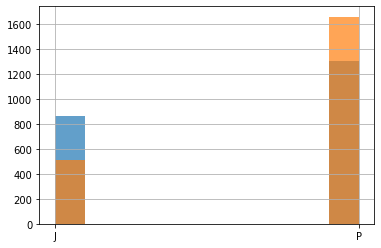

In [21]:
print(pd.Series(yPJTest).value_counts(), end='\n\n')
print(pd.Series(pjModel.predict(xPJTest)).value_counts())

pd.Series(yPJTest).hist(alpha=0.7)
pd.Series(pjModel.predict(xPJTest)).hist(alpha=0.7)
plt.show()

### Pickling our Models

In [23]:
models = {
    'models': [model, ieModel, nsModel, ftModel, pjModel],
    'usable': [False, False, False, True, True]
}
joblib.dump(models, 'models.pkl')

['models.pkl']

# Twitter

In [ ]:
document = cv.transform([' '.join(tweets)])

### Predicting MBTI Personality

In [25]:
ieModel.predict("I feel alone")

SyntaxError: ignored

In [30]:
import pandas as pd
import numpy as np
import re

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# read data
data = pd.read_csv('personality-test.csv') 

In [31]:
data.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [32]:
[p.split('|||') for p in data.head(2).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


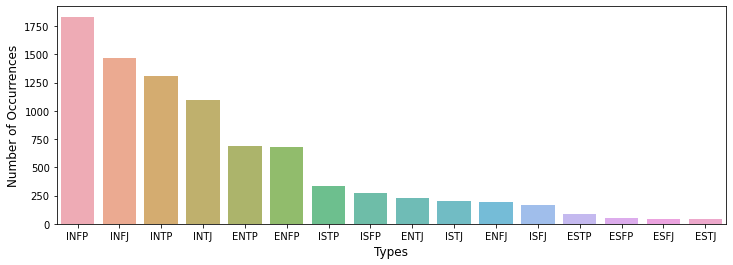

In [33]:
cnt_types = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [35]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [36]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) – Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) – Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) – Sensing (S):		 1197  /  7478
Thinking (T) – Feeling (F):		 4694  /  3981
Judging (J) – Perceiving (P):		 5241  /  3434


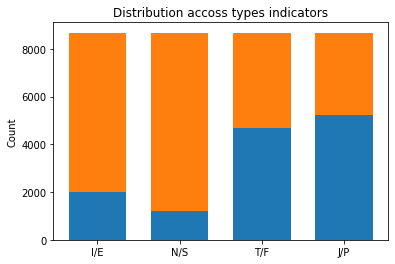

In [37]:
N = 4
but = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

In [38]:
data[['IE','NS','TF','JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,-0.069573,0.161939
NS,-0.045899,1.000000,-0.080954,0.014922
TF,-0.069573,-0.080954,1.000000,-0.004673
JP,0.161939,0.014922,-0.004673,1.000000


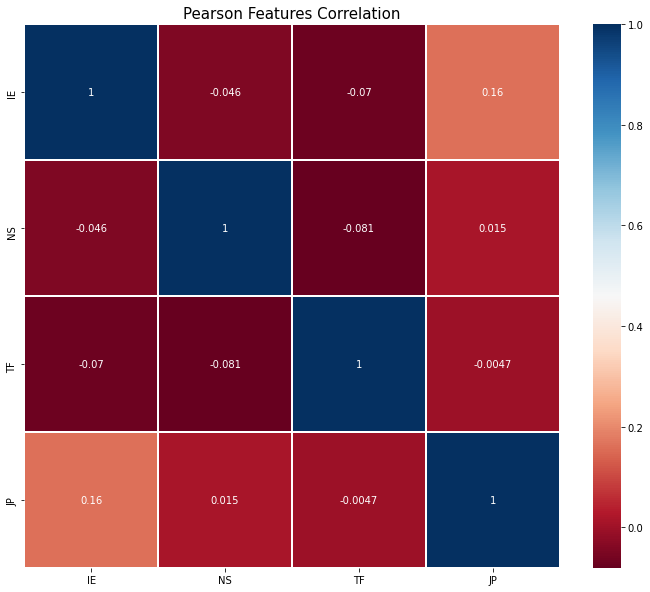

In [39]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Pearson Features Correlation', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

In [40]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

# Check ...
d = data.head(4)
list_personality_bin = np.array([translate_personality(p) for p in d.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 [0 0 1 0]]


In [42]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [43]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [45]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [46]:
list_posts, list_personality  = pre_process_data(data, remove_stop_words=True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [47]:
print("Num posts and personalities: ",  list_posts.shape, list_personality.shape)

Num posts and personalities:  (8675,) (8675, 4)


In [48]:
list_posts[0]

'   moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello  sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video game growing current favorite video game cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo  lady complimentary personality well h

In [49]:
list_personality[0]

array([0, 0, 0, 0])

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
                             max_df=0.7,
                             min_df=0.1) 

# Learn the vocabulary dictionary and return term-document matrix
print("CountVectorizer...")
X_cnt = cntizer.fit_transform(list_posts)

# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

print("Tf-idf...")
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer...
Tf-idf...


In [51]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names

[(0, 'ability'),
 (1, 'able'),
 (2, 'absolutely'),
 (3, 'accept'),
 (4, 'accurate'),
 (5, 'across'),
 (6, 'act'),
 (7, 'action'),
 (8, 'actual'),
 (9, 'actually'),
 (10, 'add'),
 (11, 'admit'),
 (12, 'advice'),
 (13, 'afraid'),
 (14, 'age'),
 (15, 'ago'),
 (16, 'agree'),
 (17, 'ah'),
 (18, 'almost'),
 (19, 'alone'),
 (20, 'along'),
 (21, 'already'),
 (22, 'although'),
 (23, 'amazing'),
 (24, 'amount'),
 (25, 'angry'),
 (26, 'animal'),
 (27, 'annoying'),
 (28, 'another'),
 (29, 'answer'),
 (30, 'anxiety'),
 (31, 'anymore'),
 (32, 'anyone'),
 (33, 'anything'),
 (34, 'anyway'),
 (35, 'apparently'),
 (36, 'appreciate'),
 (37, 'approach'),
 (38, 'area'),
 (39, 'argument'),
 (40, 'around'),
 (41, 'art'),
 (42, 'ask'),
 (43, 'asked'),
 (44, 'asking'),
 (45, 'aspect'),
 (46, 'assume'),
 (47, 'attention'),
 (48, 'attracted'),
 (49, 'avatar'),
 (50, 'avoid'),
 (51, 'aware'),
 (52, 'away'),
 (53, 'awesome'),
 (54, 'awkward'),
 (55, 'baby'),
 (56, 'back'),
 (57, 'bad'),
 (58, 'based'),
 (59, 'basi

In [52]:
X_tfidf.shape

(8675, 791)

In [53]:
print("X: Posts in tf-idf representation \n* 1st row:\n%s" % X_tfidf[0])

X: Posts in tf-idf representation 
* 1st row:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.08042209 0.06830218 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10331537 0.         0.04973404 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.10984584 0.         0.         0.         0.08642509
 0.         0.         0.10488948 0.         0.         0.
 0.         0.         0.05188886 0.06824736 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0

In [54]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) – Sensing (S)
FT: Feeling (F) - Thinking (T)
JP: Judging (J) – Perceiving (P)


In [55]:
print("MBTI 1st row: %s" % translate_back(list_personality[0,:]))
print("Y: Binarized MBTI 1st row: %s" % list_personality[0,:])

MBTI 1st row: INFJ
Y: Binarized MBTI 1st row: [0 0 0 0]


In [56]:
# First XGBoost model for MBTI dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Posts in tf-idf representation
X = X_tfidf

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    # Let's train type indicator individually
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) ...
* IE: Introversion (I) / Extroversion (E) Accuracy: 78.17%
NS: Intuition (N) – Sensing (S) ...
* NS: Intuition (N) – Sensing (S) Accuracy: 86.06%
FT: Feeling (F) - Thinking (T) ...
* FT: Feeling (F) - Thinking (T) Accuracy: 71.78%
JP: Judging (J) – Perceiving (P) ...
* JP: Judging (J) – Perceiving (P) Accuracy: 65.70%


In [57]:
# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier()
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) ...
[0]	validation_0-logloss:0.662339
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.63731
[2]	validation_0-logloss:0.616987
[3]	validation_0-logloss:0.600489
[4]	validation_0-logloss:0.585572
[5]	validation_0-logloss:0.573556
[6]	validation_0-logloss:0.564012
[7]	validation_0-logloss:0.555671
[8]	validation_0-logloss:0.548619
[9]	validation_0-logloss:0.542486
[10]	validation_0-logloss:0.537856
[11]	validation_0-logloss:0.533573
[12]	validation_0-logloss:0.529929
[13]	validation_0-logloss:0.526731
[14]	validation_0-logloss:0.523932
[15]	validation_0-logloss:0.521376
[16]	validation_0-logloss:0.519124
[17]	validation_0-logloss:0.517463
[18]	validation_0-logloss:0.515546
[19]	validation_0-logloss:0.514147
[20]	validation_0-logloss:0.512725
[21]	validation_0-logloss:0.511896
[22]	validation_0-logloss:0.510745
[23]	validation_0-logloss:0.509521
[24]	validation_0-logloss:0.508704
[25]	validation_0-loglos

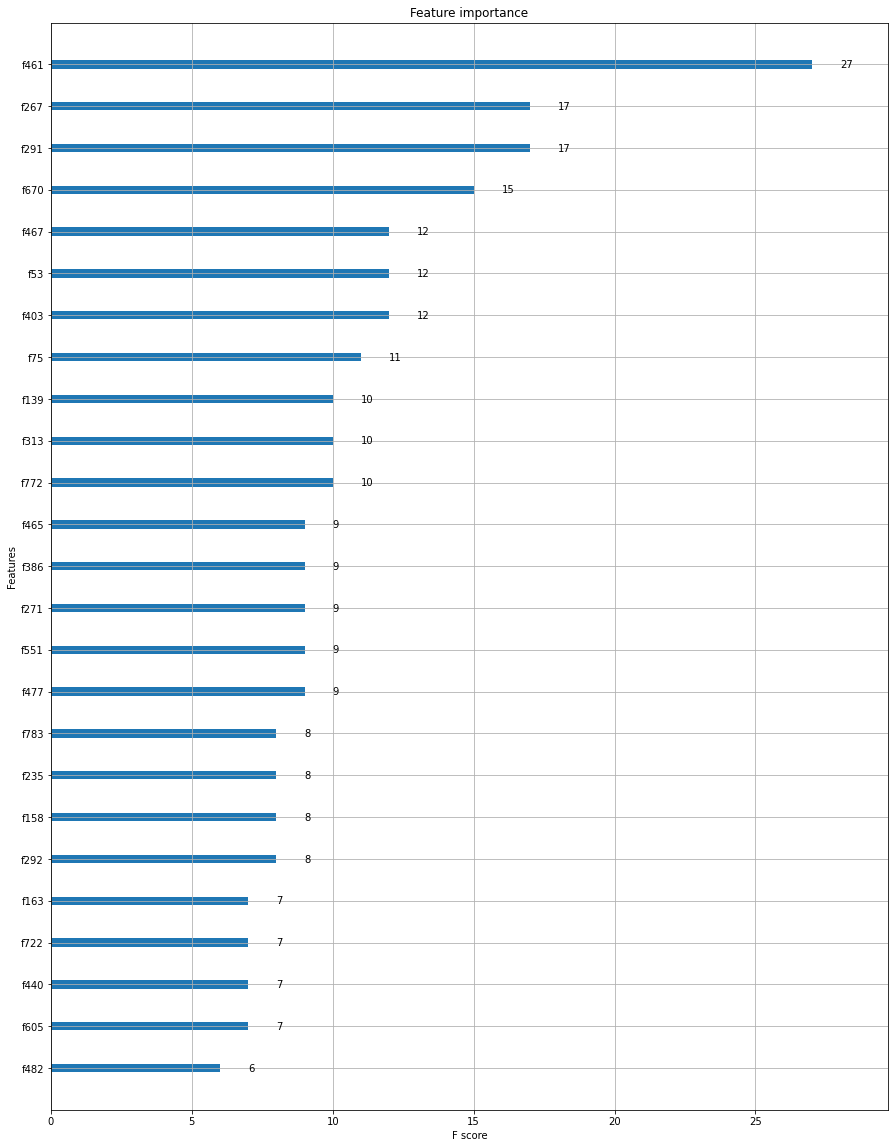

In [58]:
from xgboost import plot_importance

# Only the 1st indicator
y = list_personality[:,0]
# fit model on training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
ax = plot_importance(model, max_num_features=25)

fig = ax.figure
fig.set_size_inches(15, 20)

plt.show()

In [59]:
features = sorted(list(enumerate(model.feature_importances_)), key=lambda x: x[1], reverse=True)
for f in features[0:25]:
    print("%d\t%f\t%s" % (f[0],f[1],cntizer.get_feature_names()[f[0]]))
    
# Save xgb_params for late discussuin
default_get_xgb_params = model.get_xgb_params()

461	0.009033	ne
291	0.008526	guy
403	0.007722	lol
267	0.007063	fun
292	0.006774	haha
396	0.006556	listening
685	0.006194	tell
761	0.006189	wink
53	0.006170	awesome
183	0.006107	dream
772	0.005912	world
313	0.005892	hey
477	0.005847	nt
569	0.005841	relationship
551	0.005829	quiet
455	0.005762	music
467	0.005734	ni
139	0.005721	crazy
265	0.005697	fuck
271	0.005654	game
75	0.005644	bored
213	0.005609	everyone
629	0.005543	sometimes
26	0.005496	animal
608	0.005425	shy


In [60]:
# Save xgb_params for later discussuin
default_get_xgb_params = model.get_xgb_params()
print (default_get_xgb_params)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}


In [61]:
# setup parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) ...
* IE: Introversion (I) / Extroversion (E) Accuracy: 79.01%
NS: Intuition (N) – Sensing (S) ...
* NS: Intuition (N) – Sensing (S) Accuracy: 85.96%
FT: Feeling (F) - Thinking (T) ...
* FT: Feeling (F) - Thinking (T) Accuracy: 74.19%
JP: Judging (J) – Perceiving (P) ...
* JP: Judging (J) – Perceiving (P) Accuracy: 65.42%


In [62]:
# Tune learning_rate
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Posts in tf-idf representation
X = X_tfidf

# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2


# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]
    model = XGBClassifier(**param)
    # learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    # param_grid = dict(learning_rate=learning_rate)
    
    param_grid = {
        'n_estimators' : [ 200, 300],
        'learning_rate': [ 0.2, 0.3]
        # 'learning_rate': [ 0.01, 0.1, 0.2, 0.3],
        # 'max_depth': [2,3,4],
    }
    
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, Y)

    # summarize results
    print("* Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("* %f (%f) with: %r" % (mean, stdev, param))

IE: Introversion (I) / Extroversion (E) ...
* Best: -0.496607 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.496607 (0.009291) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.498587 (0.007900) with: {'learning_rate': 0.2, 'n_estimators': 300}
* -0.505122 (0.010825) with: {'learning_rate': 0.3, 'n_estimators': 200}
* -0.512983 (0.010218) with: {'learning_rate': 0.3, 'n_estimators': 300}
NS: Intuition (N) – Sensing (S) ...
* Best: -0.379042 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.379042 (0.009973) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.388885 (0.010717) with: {'learning_rate': 0.2, 'n_estimators': 300}
* -0.402796 (0.009740) with: {'learning_rate': 0.3, 'n_estimators': 200}
* -0.422739 (0.011320) with: {'learning_rate': 0.3, 'n_estimators': 300}
FT: Feeling (F) - Thinking (T) ...
* Best: -0.519274 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.519274 (0.019330) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.522286 (0.021975) w

In [63]:
# A few few tweets and blog post
my_posts  = """Getting started with data science and applying machine learning has never been as simple as it is now. There are many free and paid online tutorials and courses out there to help you to get started. I’ve recently started to learn, play, and work on Data Science & Machine Learning on Kaggle.com. In this brief post, I’d like to share my experience with the Kaggle Python Docker image, which simplifies the Data Scientist’s life.
Awesome #AWS monitoring introduction.
HPE Software (now @MicroFocusSW) won the platinum reader's choice #ITAWARDS 2017 in the new category #CloudMonitoring
Certified as AWS Certified Solutions Architect 
Hi, please have a look at my Udacity interview about online learning and machine learning,
Very interesting to see the  lessons learnt during the HP Operations Orchestration to CloudSlang journey. http://bit.ly/1Xo41ci 
I came across a post on devopsdigest.com and need your input: “70% DevOps organizations Unhappy with DevOps Monitoring Tools”
In a similar investigation I found out that many DevOps organizations use several monitoring tools in parallel. Senu, Nagios, LogStach and SaaS offerings such as DataDog or SignalFX to name a few. However, one element is missing: Consolidation of alerts and status in a single pane of glass, which enables fast remediation of application and infrastructure uptime and performance issues.
Sure, there are commercial tools on the market for exactly this use case but these tools are not necessarily optimized for DevOps.
So, here my question to you: In your DevOps project, have you encountered that the lack of consolidation of alerts and status is a real issue? If yes, how did you approach the problem? Or is an ChatOps approach just right?
You will probably hear more and more about ChatOps - at conferences, DevOps meet-ups or simply from your co-worker at the coffee station. ChatOps is a term and concept coined by GitHub. It's about the conversation-driven development, automation, and operations.
Now the question is: why and how would I, as an ops-focused engineer, implement and use ChatOps in my organization? The next question then is: How to include my tools into the chat conversation?
Let’s begin by having a look at a use case. The Closed Looped Incidents Process (CLIP) can be rejuvenated with ChatOps. The work from the incident detection runs through monitoring until the resolution of issues in your application or infrastructure can be accelerated with improved, cross-team communication and collaboration.
In this blog post, I am going to describe and share my experience with deploying HP Operations Manager i 10.0 (OMi) on HP Helion Public Cloud. An Infrastructure as a Service platform such as HP Helion Public Cloud Compute is a great place to quickly spin-up a Linux server and install HP Operations Manager i for various use scenarios. An example of a good use case is monitoring workloads across public clouds such as AWS and Azure.
"""

# The type is just a dummy so that the data prep fucntion can be reused
mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_data(mydata, remove_stop_words=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

1 of 1 rows


In [64]:
# setup parameters for xgboost
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

result = []
# Let's train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
    # print("* %s prediction: %s" % (type_indicators[l], y_pred))

IE: Introversion (I) / Extroversion (E) ...
NS: Intuition (N) – Sensing (S) ...
FT: Feeling (F) - Thinking (T) ...
JP: Judging (J) – Perceiving (P) ...


In [65]:
print("The result is: ", translate_back(result))

The result is:  INTJ


In [67]:
# save model to file
pickle.dump(model, open("pima.pickle.dat", "wb"))